In [1]:
#Importing necessary packages
import pandas as pd
import networkx as nx
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly as py
import operator
from fa2 import ForceAtlas2
import matplotlib.colors as pltcolors
from community import community_louvain
import seaborn as sns
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import string
import numpy as np
import math

# Explainer Notebook for final project in Social Graphs and Interactions

This notebook aims to explain all steps an calculations used for the final project in Social Graphs and Interactions (02805). The notebook has 4 main sections including the motivation behind the project, some basic stats to understand the dataset, the main analysis and finally a discussion about the findings. Please use the table of content below to navigate to the various sections.

## Table of Content
* [Motivation](#motivation)
* [Basic Stats](#basic-stats)
* [Analysis](#analysis)
* [Discussion](#discussion)
* [Helper Functions](#help)

## Motivation <a class="anchor" id="motivation"></a>

This project is investigating a network of books. We want to explore how one books is related with the books that are recommended on the books site on Goodreads, an online database of books. The objective is to investigate if the list of recommendations on highly popular books creates a network, where for example the same book are recommended all the time making them highly influential in the literary society. Another outcome could be that books are mainly recommended other books within the same genre, which could limit readers to one sub-category of books. Or maybe no patterns are found at all. 
In addition to investigating the relationsship between books, we investigate how correlated a books rating is, with the sentiment score of the book reviews. A hypothesis is that highly rating books will have a higher sentiment score in the reviews than a poorly rated book will. 
The network analysis and sentiment analysis will be tied together when investigating whether the influential nodes in the notebook are also some of the books with highest rating/sentiment or if it is something else that drives the high degree nodes. 

**The Dataset**

The information about the books are as mentioned taken from Goodreads. Goodreads has been chosen as it holds information about almost every book and therefore creates a good platform to generate uniform data across the list of books. Goodreads also contains reviews of each book, which are crucial for second part of the analysis. 

The books chosen for the network are taken from the list ["Books Everyone Should Read At Least Once"](https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once) referred to throughout this project as positive books. The list contains 21.618 books. To create the sentiment analysis poorly rated books were also necessary, and they were obtained from [Worst Rated Books on Goodreads](https://www.goodreads.com/list/show/23974.Worst_Rated_Books_on_Goodreads) referred to as negative books. This list contains 416 books. 

Information about each book was obtained by scraping the website. Acquiring the information through scraping was very slow and a time limitation forced us to chose a finite number of books from the list of positive books. To decide the exact number we took our offset in the motivation namely how one person should decide what books they should read. The chosen number of books therefore became an estimate of how many books an average person reads in a lifetime. The number is set quite high but data is also essential to create a meaningful network. We have scraped 764 books from the positive list and and all 416 from the negative list. 

The following information about each book was acquired:
* Title
* Author
* Genre
* Rating
* Rating count (how many ratings a book has)
* List of recommended books
* Top 15 reviews of book

Our hope for the results of this analysis is for the reader to gain a better understanding of why some books are recommended often while others are never recommended even though they may have a high rating. Furter, the reader should see how well a sentiment score can be used to categorize book reviews.  

## Basic Stats <a class="anchor" id="basic-stats"></a>

This section give a brief introduction to the dataset. All information scraped for the books are saved in cvs files found [here](insert_link) OBS. The code below manages reading the information into a dataframe and exploring the entries. 

In [2]:
# Reading the list of books as dataframe
pos_books = pd.read_pickle("books.pcl")

In [7]:
# Printing the first 5 entries of the dataframe
pos_books.head()

,title,author,genre,rating,rating_count,related,review
0,To Kill a Mockingbird,Harper Lee,Classics,4.27,4058926,"[Harry Potter and the Deathly Hallows, Lord of...",[[\n \n Why is it when I p...
1,Harry Potter and the Sorcerer's Stone,J.K. Rowling,Fantasy,4.47,6186514,"[Lord of the Flies, A Wrinkle in Time, Speak, ...",[[\n\n \nUPDATE OCTOBER 2019\nShould I try to ...
2,Pride and Prejudice,Jane Austen,Classics,4.25,2662196,"[Harry Potter and the Deathly Hallows, Lord of...",[[\n \n 6.0 stars. Confess...
3,The Diary of a Young Girl,Anne Frank,Nonfiction,4.13,2474246,"[Lord of the Flies, Harry Potter and the Death...",[[\nWhy do we write reviews?You have a lot of ...
4,1984,George Orwell,Classics,4.17,2711604,"[Lord of the Flies, Harry Potter and the Death...",[[\nThis book is far from perfect. Its charact...


In [8]:
printmd("**Statistics about the ratings:**")
print(f"The book with the highest rating is {pos_books.title[pos_books.rating.idxmax()]}\
with a rating of {pos_books.rating.max()}")
print(f"The book with the lowest rating is {pos_books.title[pos_books.rating.idxmin()]}\
with a rating of {pos_books.rating.min()}")
print(f"The average rating of the books are {pos_books.rating.mean():.2f}")
print()
printmd("**Statistics about the rating count:**")
print(f"The book with the highest rating count is {pos_books.title[pos_books.rating_count.idxmax()]}\
with a rating count of {pos_books.rating_count.max():,}")
print(f"The book with the lowest rating count is {pos_books.title[pos_books.rating_count.idxmin()]}\
with a rating count of {pos_books.rating_count.min():,}")
print(f"The average rating count of the books are {pos_books.rating_count.mean():,.2f}")

**Statistics about the ratings:**

The book with the highest rating is Harry Potter Series Box Setwith a rating of 4.74
The book with the lowest rating is The Scarlet Letterwith a rating of 3.39
The average rating of the books are 4.07



**Statistics about the rating count:**

The book with the highest rating count is Harry Potter and the Sorcerer's Stonewith a rating count of 6,186,514
The book with the lowest rating count is Destiny of the Vampirewith a rating count of 55
The average rating count of the books are 391,762.05


**Statistics about genre**

Next the count of entries for each genre is investigated. As seen in the output below most of the books fall into a few genres, whereas a large number of genres is only represented by 1 book. Therefore, we kept the top 10 genres and grouped the remaining into a new category called "Miscellaneous".  

In [9]:
pos_books.groupby("genre")["genre"].count().sort_values(ascending=False)

genre
Fiction              184
Classics             180
Nonfiction            76
Fantasy               74
Young Adult           40
Historical            32
Science Fiction       24
Childrens             22
Horror                18
History               14
Poetry                11
Philosophy             9
Religion               7
Sequential Art         7
Contemporary           6
Romance                6
Plays                  5
Mystery                5
Science                4
Self Help              4
Psychology             4
Christian              3
Thriller               3
Biography              2
Feminism               2
Drama                  2
Short Stories          2
Humor                  1
Autobiography          1
Book Club              1
Business               1
Spirituality           1
Christian Fiction      1
Cultural               1
Crime                  1
Economics              1
Paranormal             1
Realistic Fiction      1
Food and Drink         1
Marriage           

In [10]:
# Taking only the top 10 genres and grouping the remaining 
genres_accepted = pos_books.groupby("genre")['genre'].count().sort_values(ascending=False)[0:10]
pos_books.loc[~pos_books.genre.apply(lambda x: x in list(genres_accepted.index)), 'genre'] = "Miscellaneous"

In [11]:
pos_books.groupby("genre")["genre"].count().sort_values(ascending=False)

genre
Fiction            184
Classics           180
Miscellaneous       98
Nonfiction          76
Fantasy             74
Young Adult         40
Historical          32
Science Fiction     24
Childrens           22
Horror              18
History             14
Name: genre, dtype: int64

**Statistics about reviews**

Next we are investigating the reviews for each book. Note reviews for all positive books has not been obtained. Getting the reviews were by far the most time consuming part of the scraping and to have a more homogeneous dataset when comparing with the negative books, only reviews for the first 444 books has been obtained. 

In [12]:
books_reviewed = pos_books[pos_books.review.notna()].reset_index(drop=True)
print(f"The number of books with acquired reviews are {len(books_reviewed)}.")

The number of books with acquired reviews are 445.


In [13]:
tokenizer = RegexpTokenizer(r"\w+")

tokens_count_list = []
for j in range(len(books_reviewed)):
    tokens_count = 0
    for i in range(len(books_reviewed.review[j][0])):
        tokens = tokenizer.tokenize(books_reviewed.review[j][0][i])
        tokens_count += len(tokens)
    tokens_count_list.append(tokens_count)


In [14]:
books_reviewed = pd.concat([books_reviewed, pd.Series(tokens_count_list, name = "Token_count")], axis=1)

In [15]:
print(f"The book with the longest reviews is {books_reviewed.title[books_reviewed.Token_count.idxmax()]} \
with a token count of {books_reviewed.Token_count.max()}")
print(f"The book with the shortest reviews is {books_reviewed.title[books_reviewed.Token_count.idxmin()]} \
with a token count of {books_reviewed.Token_count.min()}")
print(f"The average token count for the reviews of the books are {books_reviewed.Token_count.mean():.2f}")

The book with the longest reviews is Cloud Atlas with a token count of 18724
The book with the shortest reviews is Guess How Much I Love You with a token count of 1108
The average token count for the reviews of the books are 6945.55


## Analysis <a class="anchor" id="analysis"></a>

First step is to create the graph representing the books. The graph is created as all the books on the list as nodes and with an edge to another book, if the node books is represented on the other books list of "readers also enjoyed" books.

In [16]:
# Generating directed graph
G = nx.DiGraph()

# Letting each node be a book from the positive list and adding rating and genre as attribute
for i in range(len(pos_books)):
    node = pos_books.iloc[i]
    G.add_node(node['title'], rating = node['rating'], genre = node['genre'])

In [17]:
# Creating edges from related books list to the books on the list
for i in range(len(pos_books)):
    node = pos_books.iloc[i]['title']
    connections = []
    for related in pos_books.iloc[i]['related']:
        if len(pos_books[pos_books['title'] == related]) == 1 :
            connections.append(related)
    for con in connections:
        G.add_edges_from([(con, node)])

In [18]:
print(f"The network consists of {nx.number_of_nodes(G)} nodes and {nx.number_of_edges(G)} edges.")

The network consists of 759 nodes and 2935 edges.


With the network the degree distribution can be investigated. 

In [19]:
printmd("**Statistics about degree**")
print(f"The node with the highest degree is \
{list(dict(G.degree()).keys())[list(dict(G.degree()).values()).index(np.max(list(dict(G.degree()).values())))]} \
with degree {np.max(list(dict(G.degree()).values()))}")
print(f"This means that \
{list(dict(G.degree()).keys())[list(dict(G.degree()).values()).index(np.max(list(dict(G.degree()).values())))]} \
is recommended for {np.max(list(dict(G.degree()).values()))/len(pos_books)*100:.2f}% of the books on the list")
print(f"The average degree is {np.mean(list(dict(G.degree()).values())):.2f}")

**Statistics about degree**

The node with the highest degree is Harry Potter and the Deathly Hallows with degree 527
This means that Harry Potter and the Deathly Hallows is recommended for 69.16% of the books on the list
The average degree is 7.73


In [20]:
# Getting unique degree and count of each for degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

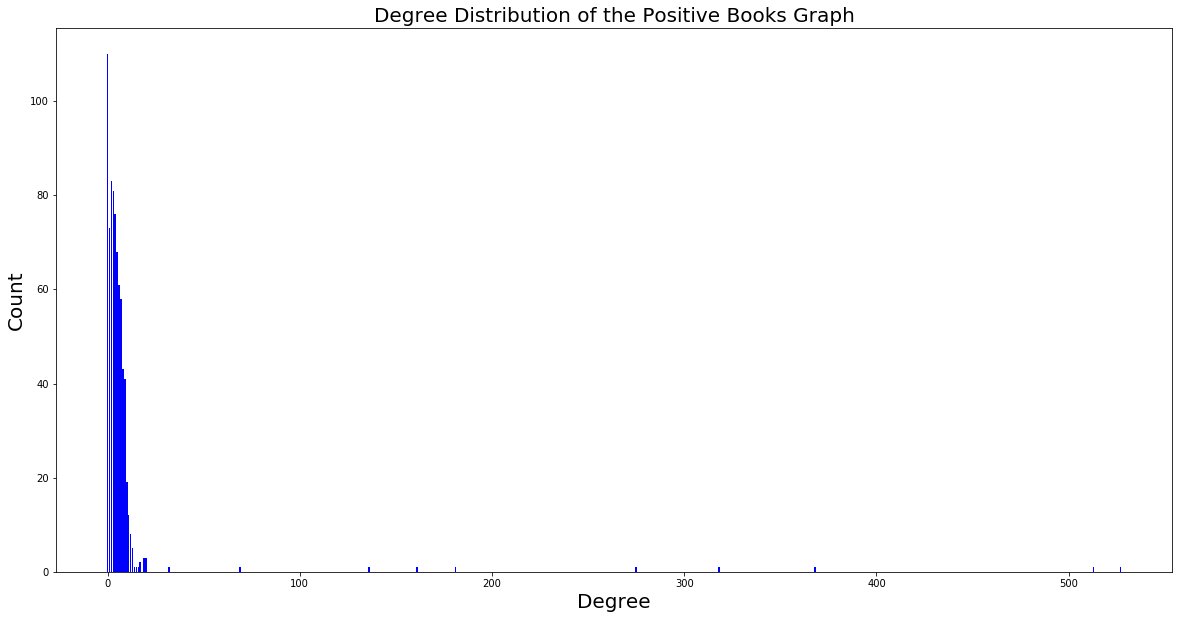

In [21]:
# Plotting degree distribution
plt.figure(figsize = (20,10))
plt.bar(deg, cnt, width=0.80, color='b')
plt.title("Degree Distribution of the Positive Books Graph", fontsize = 20)
plt.xlabel("Degree", fontsize = 20)
plt.ylabel("Count", fontsize = 20)

plt.show()

Looking at the degree distribution it is clear that few books have a very large degree while the majority of the books are have a degree under 20. This indicates that there are a few select books that gets recommended for almost every other book on the list. To investigate how central these books are for the graph the betweenness centrality and eigenvector centrality are found below. 
Betweenness centrality is a meassure of how many shortest paths passses through a given node. For our network a high betweenness centrality would indicate a gateway book, meaning if you read book A you may not be recommended book B, but you get recommended book C. Book C will then recommend you book B, and the only reason you read book B is therefore because you also read book C. This makes book C very influential. 
Eigenvector centrality is also an indicator for how influential a node is. A node gets a high score if its neighboring node also have a high score. This would for our network mean that having a high eigenvector centrality is equal to being recommended a lot and also recommended other highly recommended books. A book with high degree but low eigenvector centrality could therefore be a book that is recommended alot, but does not recommend popular book itself.

In [22]:
# We now look at the nodes with the highest degree and their centrality measures 
# and outputs the N (10) with the highest degree
N = 10

degree_sort = pd.DataFrame(list(sorted(G.degree, key=lambda x: x[1], reverse=True)), columns = ("Name", "Degree"))
eigen_sort =   pd.DataFrame(list(sorted(nx.eigenvector_centrality(G).items(), key=operator.itemgetter(1), reverse=True)), columns = ("Name", "Eigenvector centrality"))
between_sort = pd.DataFrame(list(sorted(nx.betweenness_centrality(G).items(), key=operator.itemgetter(1), reverse=True)), columns = ("Name", "Betweenness centrality"))
sort = pd.merge(pd.merge(pd.merge(degree_sort,eigen_sort,on='Name'),between_sort,on='Name'), pos_books[['title', 'genre']], left_on = 'Name', right_on = 'title')
sort = sort.drop(['title'], axis = 1)
sort = sort.sort_values('Degree', ascending=False)

In [23]:
# Displaying top 10 degree books
sort[0:N]

,Name,Degree,Eigenvector centrality,Betweenness centrality,genre
0,Harry Potter and the Deathly Hallows,527,0.128418,0.016261,Fantasy
1,Lord of the Flies,513,0.063518,0.006911,Classics
2,The Handmaid's Tale,368,0.057762,0.001968,Fiction
3,A Wrinkle in Time,318,0.044879,0.000710,Fantasy
4,Anna Karenina,275,0.039885,0.000648,Classics
5,Speak,181,0.033436,0.000311,Young Adult
6,Watership Down,161,0.045556,0.000172,Classics
7,White Oleander,136,0.048316,0.001122,Fiction
8,His Dark Materials,69,0.054026,0.002154,Fantasy
9,2001: A Space Odyssey,32,0.034543,0.000049,Science Fiction


A few interesting remarks can be made from the table above. Looking at entry 7 we see that even though it has a smaller degree than both 5 and 6 the betweenness centrality meassure is almost 10 times bigger. This indicates that "White Oleander" tends to be recommeneded through fewer iterations than "Watership Down" or "Speak" do. Further, it is noticed that "His Dark Materials" at enty 8 has a higher eigenvector centrality than both 7, 6, 5, 4, and 3. This shows that "His Dark Materials" recommeds the popular books more. 

### Visulalizing the Network

In [24]:
def set_generic_node_attributes(G, color_by, scaling=1, grav=1, log=False,  n_f2_iter=2000):
    '''
    Function to get colors given a given group, and initialise the Force Atalas algorithm. 
    
    Parameters:
    G: networkx graph with attribute color_by
    color_by: attribute in graph G that graph should be colored by
    scaling: hyperparameter for Force Atlas algorithm. By default set to 1
    grav: gravity hyperparameter for Force Atlas algorithm. By default set to 1
    log: if True progress bar of tuning of Force Atlas will be displayed
    n_f2_iter: number of iterations for Force Atlas algorithm. By default set to 2000
    
    Return:
    colors: map for color of node in graph
    pos: positions for nodes in graph
    '''
    
    # Getting mapping of colors for nodes to seperate on genre:
    groups = set(nx.get_node_attributes(G,color_by).values())
    colors_tmp = list(pltcolors._colors_full_map.values())[0:len(groups)]
    cmap = dict(zip(groups, colors_tmp))
    nodes = G.nodes()
    colors = [cmap.get(G.node[n][color_by]) for n in nodes]

    #Defining positions using Force Atlas algorithm
    forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=scaling,
                        strongGravityMode=False,
                        gravity=grav,

                        # Log
                        verbose=log)
    
    pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=n_f2_iter)
    
    return colors, pos

In [41]:
# Getting color and position for plotting with color based on genre
color, pos = set_generic_node_attributes(G, 'genre', scaling=2, grav=1.8, log=False,  n_f2_iter=2000)
degree_list = list(dict(G.degree()).values())
size = [(x + 1)*20 for x in degree_list]

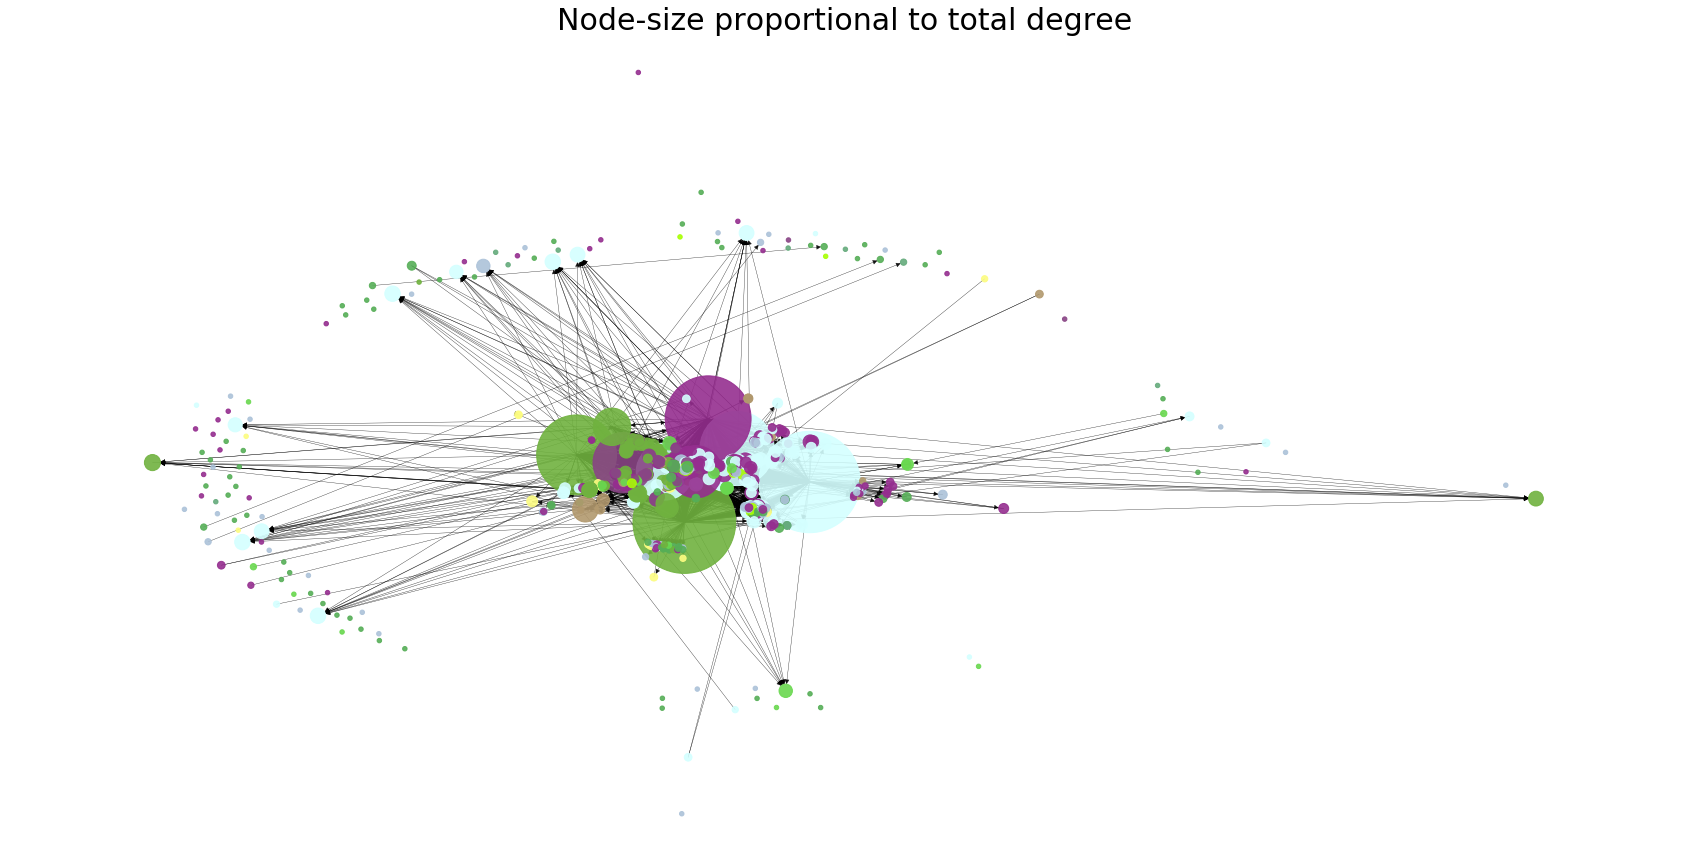

In [43]:
plt.figure(figsize=(30, 15))
plt.title("Node-size proportional to total degree", fontsize = 30)
nx.draw(G, pos, node_size=size, with_labels=False, width = 0.35, node_color=color, alpha=0.9)

This figures shows the network with node size proportional to total degree and color based on genre. No clear hubs of genre are seen, but the illustration supports the previously seen finding about the degree. Few node, here represented in the middle, have very large degree and drive much of the network. 

### Community Detection

Simply looking at the illustrations does, as mentioned, not indicate much clustering based on genres. But further investigation of the modularity score and community detection is needed in order to see, how well the genre actually do in clustering the data. 


## Helper Functions <a class="anchor" id="help"></a>


In [5]:
# Packages used only for helper functions
from IPython.display import Markdown, display

In [6]:
def printmd(string):
    display(Markdown(string))